In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import cv2
import numpy as np

In [5]:
base_dir = "../data/tyre_classifier/"
for folder in  os.listdir(base_dir):
    for file in os.listdir(os.path.join(base_dir, folder)):
        file_path = os.path.join(base_dir, folder,file)
        try:
            cv2.imread(file_path)
        except:
            print("Error", file_path)


In [29]:
data = tf.keras.utils.image_dataset_from_directory(base_dir)
data = data.map(lambda x, y : (x//255, y))

Found 1856 files belonging to 2 classes.


In [ ]:
# convert images to tfrecord for fast training.
def serialize_images_to_tfrecord(
    image_paths, labels, filename, /, size=(224, 224), compression="GZIP"
):
    height, width = size
    options = tf.io.TFRecordOptions(compression_type=compression)
    resizing = layers.Resizing(height=height, width=width, crop_to_aspect_ratio=True)

    with tf.io.TFRecordWriter(filename, options) as f:
        for image_path, label in zip(image_paths, labels):
            image = tf.io.decode_jpeg(tf.io.read_file(image_path), channels=3)
            image_resized = tf.cast(resizing(image), dtype=tf.uint8)
            image_encoded = tf.io.encode_jpeg(image_resized)
            example = Example(
                features=Features(
                    feature={
                        "image": Feature(bytes_list=BytesList(value=[image_encoded.numpy()])),
                        "label": Feature(int64_list=Int64List(value=[label])),
                    }
                )
            )
            f.write(example.SerializeToString())

In [31]:
for batch in data.as_numpy_iterator():
    print(batch[0][1].max())
    print(batch[1][0])
    break

1.0
1


1


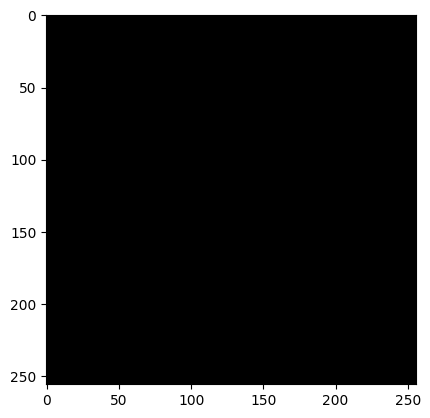

In [32]:
plt.imshow(batch[0][0].astype(int))
print(batch[1][0])

In [33]:
train_size = int(len(data) * 0.7)
val_size = int(len(data) * 0.2) + 1
test_size = int(len(data) * 0.1)
train_size, val_size, test_size

(40, 12, 5)

In [34]:
train_dataset = data.take(train_size)
val_dataset = data.skip(train_size).take(val_size)
test_dataset = data.skip(train_size + val_size).take(test_size)

In [35]:
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Flatten

In [ ]:
# normalization_layer = layers.Rescaling(1./255)
model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255, input_shape=(240, 240, 3)),
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation="sigmoid")

])


In [42]:
model = tf.keras.models.Sequential()

model.add(Conv2D(16, (3,3), 1, activation="relu", input_shape=(256, 256, 3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation="relu"))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation="relu"))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation="relu"))
model.add(Dense(50, activation="relu"))
model.add(Dense(1, activation="sigmoid"))

model.compile("adam", loss=tf.losses.BinaryCrossentropy(), metrics=["accuracy"])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 127, 127, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 30, 30, 16)       

In [43]:
hist = model.fit(train_dataset, epochs=3, validation_data=val_dataset)

Epoch 1/3


13/40 [========>.....................] - ETA: 17s - loss: 0.6960 - accuracy: 0.5745

KeyboardInterrupt: 

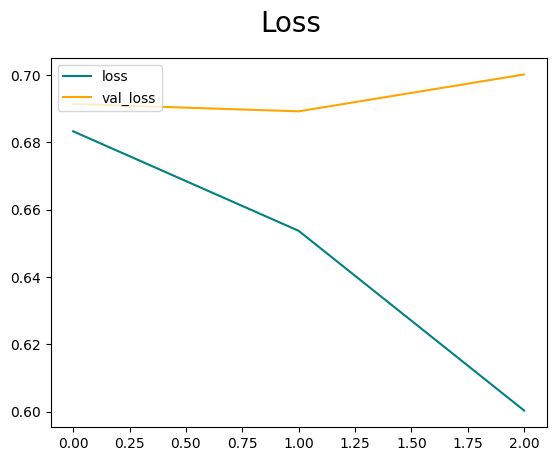

In [38]:
fig = plt.figure()
plt.plot(hist.history["loss"], color="teal", label="loss")
plt.plot(hist.history["val_loss"], color="orange", label="val_loss")
fig.suptitle("Loss", fontsize=20)
plt.legend(loc="upper left")
plt.show()

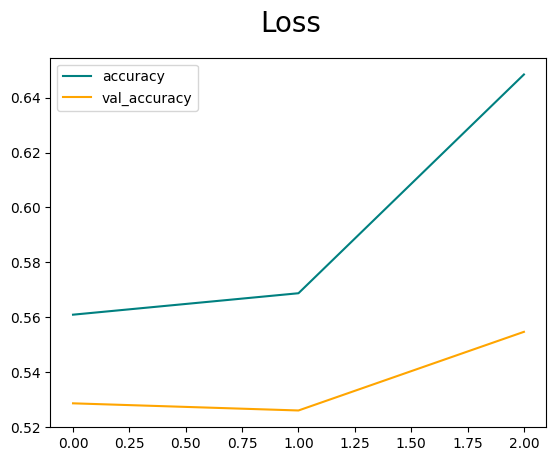

In [39]:
fig = plt.figure()
plt.plot(hist.history["accuracy"], color="teal", label="accuracy")
plt.plot(hist.history["val_accuracy"], color="orange", label="val_accuracy")
fig.suptitle("Loss", fontsize=20)
plt.legend(loc="upper left")
plt.show()

## Custom Layers

In [ ]:
class GeneralizedSwish(keras.layers.Layer):
    def __init__(self, beta=1.0, **kwargs):
        super().__init__(**kwargs)
        self.beta = tf.Variable(
            initial_value=beta,
            trainable=kwargs.get("trainable", True),
            dtype=tf.float32,
            name=self.name + "/beta",
        )

    def call(self, inputs):
        return inputs / (1.0 + tf.exp(-self.beta * inputs))

    def get_config(self):
        return super().get_config() | {
            "beta": self.beta.numpy(),
        }

In [ ]:
class MaxDepthPool2D(keras.layers.Layer):
    def __init__(self, pool_size=2, **kwargs):
        super().__init__(**kwargs)
        self.pool_size = pool_size

    def call(self, inputs):
        shape = tf.shape(inputs)  # The number of channels is stored in shape[-1].
        groups = shape[-1] // self.pool_size  # Number of channel groups.
        new_shape = tf.concat([shape[:-1], [groups, self.pool_size]], axis=0)
        return tf.reduce_max(tf.reshape(inputs, new_shape), axis=-1)

    def get_config(self):
        return super().get_config() | {
            "pool_size": self.pool_size,
        }